### Libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from goatools.obo_parser import GODag
from scipy.stats import chi2_contingency
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

### Data Loading

In [4]:
#load OE expression data
oe_tpm = pd.read_csv('../data/oe_tpm_counts_kallisto.csv', index_col=0)
#log transform
oe_log_tpm = np.log(oe_tpm + 1)
#remove suffix
oe_log_tpm.columns = oe_log_tpm.columns.str.replace(r'-v1\.0\.a2$', '', regex=True)

#load GO data
oe_gene_go_data = pd.read_csv('../data/OE_RNA_scaffolded_interproscan.csv')
go_dag = GODag("../data/go-basic.obo")

# Function to get the first GO term and map to biological process
def get_biological_process(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        return go_dag[first_go].name
    else:
        return None

oe_gene_go_data['biological_process'] = oe_gene_go_data['GO Terms'].apply(get_biological_process)

# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "biological_process" in each group
oe_go_df = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "biological_process" columns
oe_go_df = oe_go_df[['mRNA', 'biological_process']]

#############################################################################################
#get molecular function
# Function to get the first GO term and map to molecular function
def get_molecular_function(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        term = go_dag[first_go]
        if term.namespace == 'molecular_function':
            return term.name
    return None

oe_gene_go_data['molecular_function'] = oe_gene_go_data['GO Terms'].apply(get_molecular_function)

# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "molecular_function" in each group
oe_go_df_mol_funct = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "molecular_function" columns
oe_go_df_mol_funct = oe_go_df_mol_funct[['mRNA', 'molecular_function']]

#############################################################################################
#get cellular component
# Function to get the first GO term and map to Cellular Component
def get_cellular_component(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        term = go_dag[first_go]
        if term.namespace == 'cellular_component':
            return term.name
    return None

# Apply function to retrieve Cellular Component terms
oe_gene_go_data['cellular_component'] = oe_gene_go_data['GO Terms'].apply(get_cellular_component)

# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "cellular_component" in each group
oe_go_df_cell_comp = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "cellular_component" columns
oe_go_df_cell_comp = oe_go_df_cell_comp[['mRNA', 'cellular_component']]

# Reset the index of oe_log_tpm to merge on the gene ids (columns)
oe_log_tpm_melted = oe_log_tpm.reset_index().melt(id_vars='index', var_name='mRNA', value_name='expression')
oe_log_tpm_melted = oe_log_tpm_melted.rename(columns={'index': 'sample_id'})

# Merge with oe_go_df to include biological processes
merged_df = oe_log_tpm_melted.merge(oe_go_df, on='mRNA', how='left')

# Group by sample_id and biological_processes and sum the expression values
biological_process_grouped_df = merged_df.groupby(['sample_id', 'biological_process']).agg({'expression': 'sum'}).reset_index()

# Pivot the table to have biological processes as columns and sample ids as index
biological_process_df = biological_process_grouped_df.pivot(index='sample_id', columns='biological_process', values='expression').fillna(0)


# Merge with oe_go_df to include molecular functions
merged_df = oe_log_tpm_melted.merge(oe_go_df_mol_funct, on='mRNA', how='left')

# Group by sample_id and molecular_functions and sum the expression values
molecular_function_grouped_df = merged_df.groupby(['sample_id', 'molecular_function']).agg({'expression': 'sum'}).reset_index()

# Pivot the table to have molecular function as columns and sample ids as index
molecular_function_df = molecular_function_grouped_df.pivot(index='sample_id', columns='molecular_function', values='expression').fillna(0)


# Merge with oe_go_df to include cellular component functions
merged_df = oe_log_tpm_melted.merge(oe_go_df_cell_comp, on='mRNA', how='left')

# Group by sample_id and molecular_functions and sum the expression values
cellular_component_grouped_df = merged_df.groupby(['sample_id', 'cellular_component']).agg({'expression': 'sum'}).reset_index()

# Pivot the table to have molecular function as columns and sample ids as index
cellular_component_df = cellular_component_grouped_df.pivot(index='sample_id', columns='cellular_component', values='expression').fillna(0)

#Add stages
biological_process_df['Stage'] = biological_process_df.index.str[5]
molecular_function_df['Stage'] = molecular_function_df.index.str[5]
cellular_component_df['Stage'] = cellular_component_df.index.str[5]


../data/go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms


### PCA

In [70]:
#biological processes
bio_proc_pca = PCA(n_components=2)
bio_proc_pca_result = bio_proc_pca.fit_transform(biological_process_df.drop(columns='Stage'))
# Create a DataFrame for the PCA results
bio_proc_pca_df = pd.DataFrame(data=bio_proc_pca_result, columns=['PC1', 'PC2'])
bio_proc_pca_df['Stage'] = biological_process_df['Stage'].values
# Get explained variance ratio
explained_variance = bio_proc_pca.explained_variance_ratio_
print("Explained variance by PC1:", explained_variance[0])
print("Explained variance by PC2:", explained_variance[1])

#molecular functions
molec_funct_pca = PCA(n_components=2)
molec_funct_pca_result = molec_funct_pca.fit_transform(molecular_function_df.drop(columns='Stage'))
# Create a DataFrame for the PCA results
molec_funct_pca_df = pd.DataFrame(data=molec_funct_pca_result, columns=['PC1', 'PC2'])
molec_funct_pca_df['Stage'] = molecular_function_df['Stage'].values

#cellular components
cell_comp_pca = PCA(n_components=2)
cell_comp_pca_result = cell_comp_pca.fit_transform(cellular_component_df.drop(columns='Stage'))
# Create a DataFrame for the PCA results
cell_comp_pca_df = pd.DataFrame(data=cell_comp_pca_result, columns=['PC1', 'PC2'])
cell_comp_pca_df['Stage'] = cellular_component_df['Stage'].values

Explained variance by PC1: 0.9722164600678282
Explained variance by PC2: 0.0174943393708003


### Plot

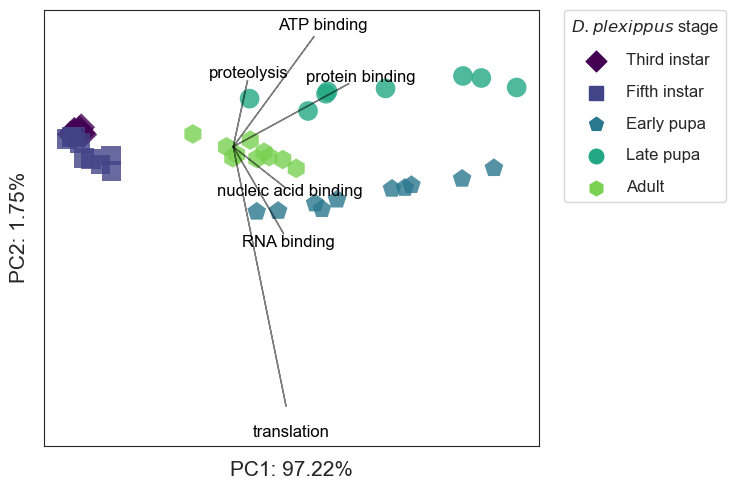

In [81]:
sns.set_style("white")
#define color palette
# Get the "Spectral" colormap
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 5
colors = [cmap(i / num_bins) for i in range(num_bins)]
# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))
hue_order = ['3', '5', 'E', 'L', 'A']

# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='Stage', style = 'Stage', 
                data=bio_proc_pca_df, ax=ax1, markers=['D', 's', 'h', 'p', 'o'],
               s=200, alpha=0.8, edgecolor = 'none', hue_order=hue_order)

# Compute the magnitude of the loadings and select the top 5
loadings = bio_proc_pca.components_.T
magnitudes = np.sqrt(np.sum(loadings**2, axis=1))
top_indices = np.argsort(magnitudes)[-6:]

# Define a scaling factor for better visibility of vectors
scaling_factor = 400

# Add vectors for the top 5 biological processes
for i in top_indices:
    ax1.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor, color='black', alpha=0.5)
    ax1.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1, biological_process_df.columns[i], 
             color='black', ha='center', va='center', fontsize=12)
    
ax1.set_xlabel('PC1: 97.22%', size=15)
ax1.set_ylabel('PC2: 1.75%', size=15)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

handles, previous_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, 
           labels=['Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12, title=r'${D. plexippus}$ stage', 
           title_fontsize = 12, labelspacing = 1, markerscale=1.75)

ax1.set_ylim(-350, 160)
plt.tight_layout()

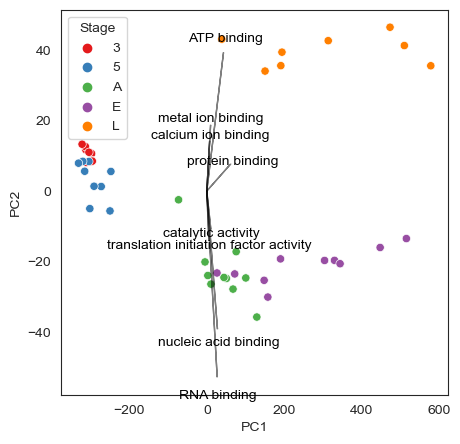

In [26]:
sns.set_style("white")

# Create the plot using ax
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='Stage', data=molec_funct_pca_df, palette='Set1', ax=ax1)

# Compute the magnitude of the loadings and select the top 5
loadings = molec_funct_pca.components_.T
magnitudes = np.sqrt(np.sum(loadings**2, axis=1))
top_indices = np.argsort(magnitudes)[-8:]

# Define a scaling factor for better visibility of vectors
scaling_factor = 90

# Add vectors for the top 5 molecular processes
for i in top_indices:
    ax1.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor, color='black', alpha=0.5)
    ax1.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1, molecular_function_df.columns[i], color='black', ha='center', va='center')
    

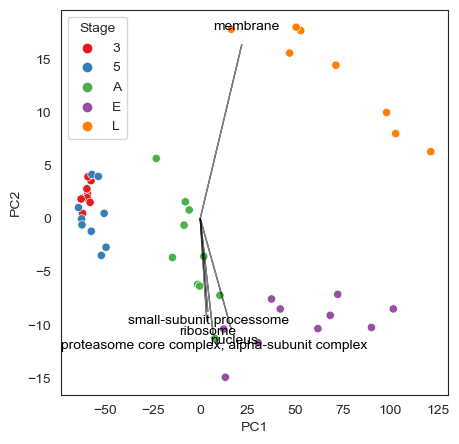

In [29]:
sns.set_style("white")

# Create the plot using ax
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='Stage', data=cell_comp_pca_df, palette='Set1', ax=ax1)

# Compute the magnitude of the loadings and select the top 5
loadings = cell_comp_pca.components_.T
magnitudes = np.sqrt(np.sum(loadings**2, axis=1))
top_indices = np.argsort(magnitudes)[-5:]

# Define a scaling factor for better visibility of vectors
scaling_factor = 30

# Add vectors for the top 5 biological processes
for i in top_indices:
    ax1.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor, color='black', alpha=0.5)
    ax1.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1, cellular_component_df.columns[i], color='black', ha='center', va='center')